## Part 1: ROC Curve
Pseduo code for a ROC Curve:

function ROC_curve(probabilities, labels):

    Sort instances by their prediction strength (the probabilities)
    For every instance in increasing order of probability:
        Set the threshold to be the probability
        Set everything above the threshold to the positive class
        Calculate the True Positive Rate (aka sensitivity or recall)
        Calculate the False Positive Rate (1 - specificity)
    Return three lists: TPRs, FPRs, thresholds

In [1]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
# updated this to the current version of sklearn
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

%matplotlib inline

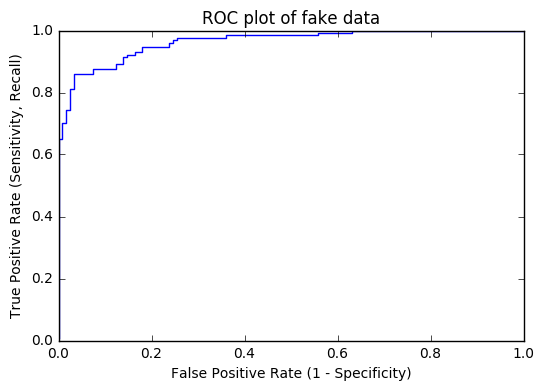

             precision    recall  f1-score   support

          0       0.87      0.91      0.89       122
          1       0.91      0.88      0.89       128

avg / total       0.89      0.89      0.89       250

[[111  11]
 [ 16 112]]


In [16]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# tpr, fpr, thresholds = roc_curve(probabilities, y_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

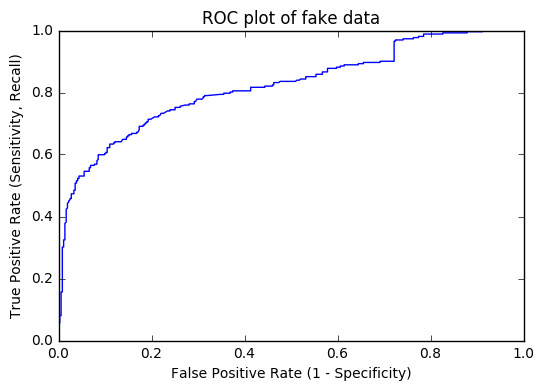

             precision    recall  f1-score   support

      False       0.80      0.80      0.80       363
       True       0.72      0.71      0.72       262

avg / total       0.77      0.77      0.77       625

[[292  71]
 [ 75 187]]


In [2]:
import pandas as pd
df = pd.read_csv('data/loanf.csv')
y = (df['Interest.Rate'] <= 12).values
X = df[['FICO.Score', 'Loan.Length', 'Loan.Amount']].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probabilities)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

## Part 2: Data Exploration: Graduate School Admissions

In [22]:
df = pd.read_csv('data/grad.csv')
df.describe()

['admit' 'gre' 'gpa' 'rank']


,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [30]:
ct = pd.crosstab(df['admit'], df['rank'])
ct

rank,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


In [32]:
ct.sum()

rank
1     61
2    151
3    121
4     67
dtype: int64

In [ ]:
# weights = np.ones_like(myarray)/float(len(myarray))
# plt.hist(myarray, weights=weights)

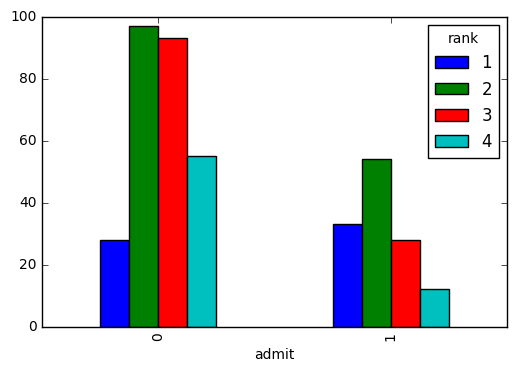

In [38]:
ct.plot(kind='bar');

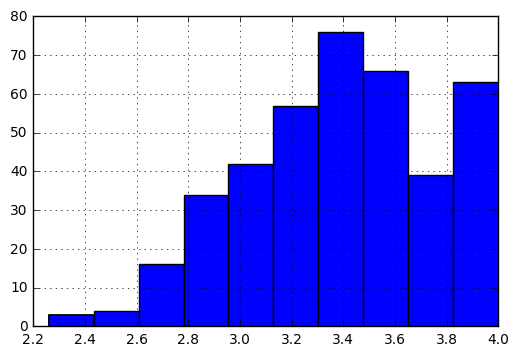

In [45]:
df['gpa'].hist();

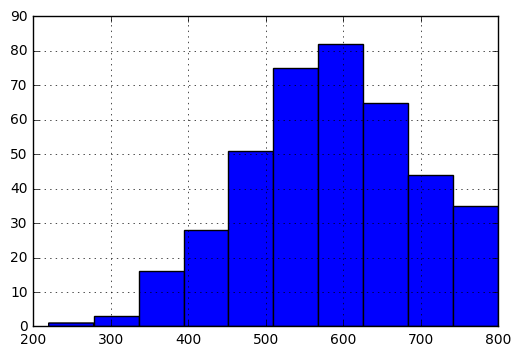

In [46]:
df['gre'].hist();

### The classes are unbalanced

In [35]:
df.groupby('admit').count()

,gre,gpa,rank
admit,,,
0,273,273,273
1,127,127,127


### Are the input features related?

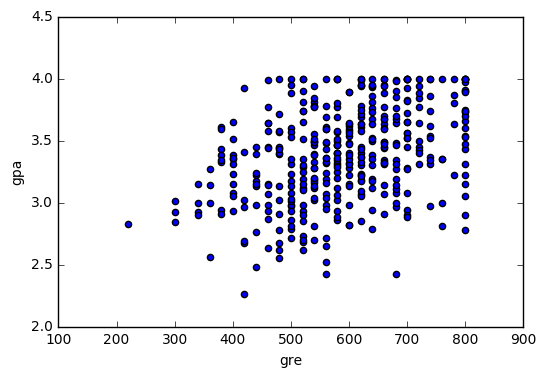

In [19]:
df.plot(x='gre', y='gpa', kind='scatter');

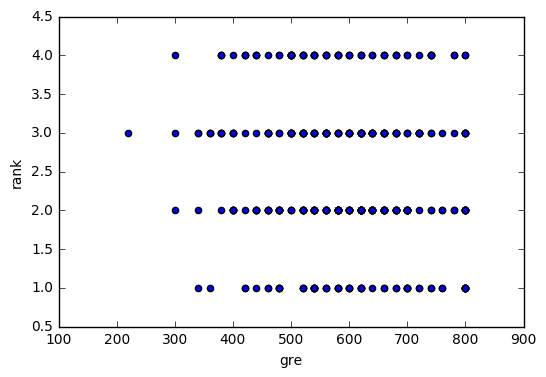

In [20]:
df.plot(x='gre', y='rank', kind='scatter');

## Part 3: Predicting Graduate School Admissions

In [132]:
from statsmodels.discrete.discrete_model import Logit

df = pd.read_csv('data/grad.csv')
y = df['admit'].values
X = df[['gre', 'gpa', 'rank']].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=555)

# model = Logit(y_train, X_train)
model = Logit(y, X)
thing = model.fit()
thing.summary()

Optimization terminated successfully.
         Current function value: 0.586372
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Apr 2017   Pseudo R-squ.:                 0.06176
Time:                        16:49:29   Log-Likelihood:                -234.55
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 1.971e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0015      0.001      1.420      0.155      -0.001       0.004
x2            -0.0042      0.201     -0.021      0.983      -0.398       0.390
x3            -0.6695      0.121     -5.527      0.000      -0.907      -0.432
==============================================================================
"""

### Are the p-values for the beta coefficients significant?
Are beta coefficients the same as the theta coefficients in the Stanford lectures? Yes

The coefficients for x1 (gre score) and x3 (rank) are significant-ish. The coefficient for x2 (gpa) is not.

In [108]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y = df['admit'].values
X = df[['gre', 'gpa', 'rank']].values

model = LogisticRegression()

k_fold = KFold(n_splits=3)

print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    model.fit(X[train], y[train])
    y_pred = model.predict(X[test])
    print("[fold {0}], accuracy_score: {1: .5f}, precision_score: {2:.5f}, recall_score: {3:.5f}".
          format(
            k,
            accuracy_score(y[test], y_pred),
            precision_score(y[test], y_pred),
            recall_score(y[test], y_pred),
        )
    )
#     Coefficient of the features in the decision function.
    print model.coef_

subsets of the data:
[fold 0], accuracy_score:  0.75373, precision_score: 0.78571, recall_score: 0.26829
[[ 0.00099238  0.27763049 -0.49337758]]
[fold 1], accuracy_score:  0.73684, precision_score: 0.70000, recall_score: 0.17949
[[ 0.00196837  0.21608631 -0.5842093 ]]
[fold 2], accuracy_score:  0.66165, precision_score: 0.54545, recall_score: 0.25532
[[ 0.00254583  0.21669211 -0.75458861]]


#### Version without Kfolds

In [118]:
y = df['admit'].values
X = df[['gre', 'gpa', 'rank']].values

"""
Why are the coefficients different for statsmodels vs sklearn?

The parameter estimates from the scikit-learn estimation are uniformly
smaller in magnitude than the statsmodels counterpart. This might lead you
to believe that scikit-learn applies some kind of parameter regularization.
There is no way to switch off regularization in scikit-learn, but you can
make it ineffective by setting the tuning parameter C to a large number.
"""
model = LogisticRegression(fit_intercept=False, C=1e9)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=555)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy_score: {0: .5f}, precision_score: {1:.5f}, recall_score: {2:.5f}".
      format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
    )
)
#     Coefficient of the features in the decision function.
print model.coef_

accuracy_score:  0.67000, precision_score: 0.57143, recall_score: 0.22857
[[ 0.0018021  -0.05564132 -0.70607813]]


### Binarize the rank data
This does not help

In [52]:
binarized_rank = pd.get_dummies(df, prefix='rank', columns=['rank'])

y = binarized_rank['admit'].values
X = binarized_rank.drop('admit', axis=1).values

model = LogisticRegression()
k_fold = KFold(n_splits=3)

print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    model.fit(X[train], y[train])
    y_pred = model.predict(X[test])
    print("[fold {0}], accuracy_score: {1: .5f}, precision_score: {2:.5f}, recall_score: {3:.5f}".
          format(
            k,
            accuracy_score(y[test], y_pred),
            precision_score(y[test], y_pred),
            recall_score(y[test], y_pred),
        )
    )

subsets of the data:
[fold 0], accuracy_score:  0.71642, precision_score: 0.57895, recall_score: 0.26829
[fold 1], accuracy_score:  0.71429, precision_score: 0.57143, recall_score: 0.10256
[fold 2], accuracy_score:  0.65414, precision_score: 0.52632, recall_score: 0.21277


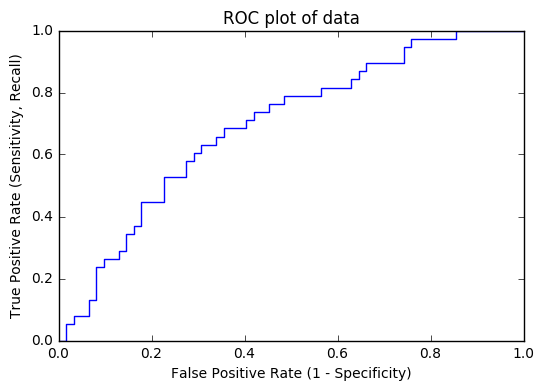

             precision    recall  f1-score   support

          0       0.65      0.92      0.76        62
          1       0.58      0.18      0.28        38

avg / total       0.62      0.64      0.58       100

[[57  5]
 [31  7]]


In [96]:
y = df['admit'].values
X = df[['gre', 'gpa', 'rank']].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probabilities)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of data")
plt.show()

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

### Is it possible to pick a threshold where TPR > 60% and FPR < 40%? What is the threshold?

In [94]:
import numpy as np

data = np.array([fpr, tpr, thresholds])
temp = pd.DataFrame(data.T, columns=['fpr', 'tpr', 'thresholds'])

# why is one of the thresholds 1.6??
tpr_60 = temp[temp.tpr > 0.6]
fpr_40 = tpr_60[tpr_60.fpr < 0.4]
     
fpr_40

,fpr,tpr,thresholds
18,0.214286,0.733333,0.365549
19,0.228571,0.733333,0.363392
20,0.228571,0.766667,0.356402
21,0.314286,0.766667,0.342723
22,0.314286,0.800000,0.334115


### Say we are using this as a first step in the application process. We want to weed out clearly unqualified candidates, but not reject too many candidates. What might be a good choice of threshold?

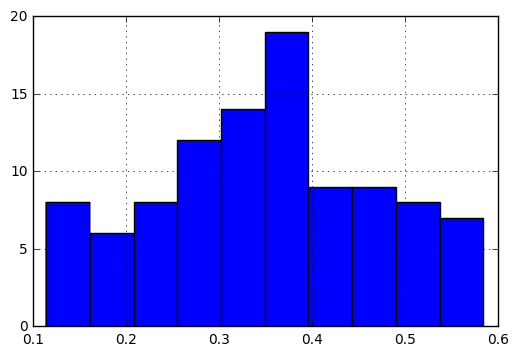

In [99]:
pd.Series(probabilities).hist();

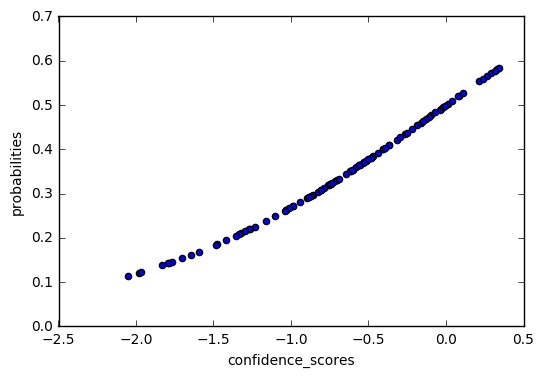

In [106]:
confidence_scores = model.decision_function(X_test)
data = np.array([confidence_scores, probabilities])
what = pd.DataFrame(data.T, columns=['confidence_scores', 'probabilities'])
what.plot(x='confidence_scores', y='probabilities', kind='scatter');

### Part 4: Interpreting the beta coefficients with the Odds Ratio

#### Fit a Logistic Regression model on all the data. What are the beta coefficients?

In [140]:
y = df['admit'].values
X = df[['gre', 'gpa', 'rank']].values

"""
Why are the coefficients different for statsmodels vs sklearn?

The parameter estimates from the scikit-learn estimation are uniformly
smaller in magnitude than the statsmodels counterpart. This might lead you
to believe that scikit-learn applies some kind of parameter regularization.
There is no way to switch off regularization in scikit-learn, but you can
make it ineffective by setting the tuning parameter C to a large number.
"""
model = LogisticRegression(fit_intercept=False, C=1e9)


model.fit(X, y)

# Coefficient of the features in the decision function.
# Beta or Theta depending on who is teaching
print 'gre, gpa, rank'
print model.coef_

gre, gpa, rank
[[ 0.00147863 -0.00599466 -0.66720157]]


The Odds Ratio represents the relative change in odds due to a 1-unit change in the feature. 

In [125]:
import math

coeffs = model.coef_
odds_ratio_gre = math.exp(coeffs[:,0])
print odds_ratio_gre

1.00147972401


Increasing the GRE score by 1 point increases the odds by a factor of 1.0014

In [126]:
odds_ratio_gpa = math.exp(coeffs[:,1])
print odds_ratio_gpa

0.994023267975


Increasing the GPA score by 1 point increases the odds by a factor of 0.994

In [127]:
odds_ratio_rank = math.exp(coeffs[:,2])
print odds_ratio_rank

0.513142564051


Increasing the Rank by 1 point increases the odds by a factor of 0.51. This is backwards, because the Rank is a discrete variable, where 1 is the best rank and 4 is the lowest rank.

#### What change is required to double my chances of admission? Treat each of the features individually.

In [129]:
# For GRE
k = math.log(2)/coeffs[:,0]
print k

[ 468.77652963]


In [130]:
# For GPA
k = math.log(2)/coeffs[:,1]
print k
# This seems very wrong. The p value for this coefficient was the worst.

[-115.62735801]


In [131]:
# For Rank
k = math.log(2)/coeffs[:,2]
print k

[-1.03888721]


### Part 5: Predicted Probabilities

In [137]:
def fake_ranks(gre, gpa):
    ranks = np.array([1, 2, 3, 4])
    gre = np.array([gre, gre, gre, gre])
    gpa = np.array([gpa, gpa, gpa, gpa])
    data = np.array([gre, gpa, ranks])
    return pd.DataFrame(data.T, columns=['gre', 'gpa', 'rank'])

fake = pd.concat([fake_ranks(row['gre'], row['gpa']) for index, row in df.iterrows()])

In [147]:
# These will always sum to 0, so with 2 classes, this is redundant. 
# In this case, the second column is the one we should use since it has 
# the probabilities we expect.

probs = model.predict_proba(fake.values)
# First column is the probability that the data belong to class 0
prob_0 = probs[:, 0]
# Second column is the probability that the data belong to class 1
prob_1 = probs[:, 1]

In [158]:
odds = prob_1 / (1 - prob_1)

In [150]:
fake['prob_1'] = prob_1

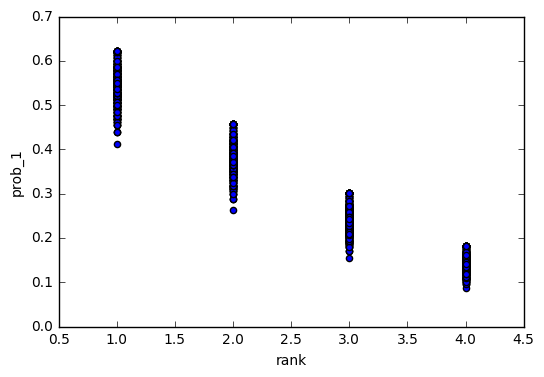

In [152]:
fake.plot(x='rank', y='prob_1', kind='scatter');



Since a linear change in rank changes the probability by a multiplicative factor, we should really be graphing rank vs the log-odds.

The slope of this line should be the beta coefficient. Eyeball calculating the slope to confirm this.


In [159]:
fake['log_odds'] = np.log(odds)

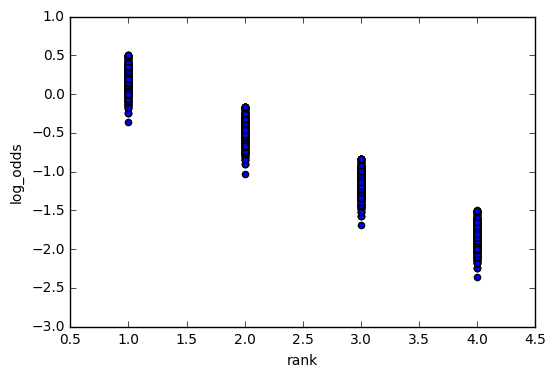

In [160]:
fake.plot(x='rank', y='log_odds', kind='scatter');